In [1]:
using NetCDF, PyPlot, BitInformation
using TranscodingStreams, CodecZstd
using Dates
using ColorSchemes, Statistics, StatsBase
using PyCall
cartopy = pyimport("cartopy")
ccrs = pyimport("cartopy.crs");

In [2]:
ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
path= "/network/aopp/chaos/pred/kloewer/esowc/cams/cams_no2_20191201_v3.nc"
ncfile = NetCDF.open(path)
no2 = ncfile.vars["no2"][:,:,137]
lat = ncfile.vars["lat"][:]
lon = ncfile.vars["lon"][:];

path= "/network/aopp/chaos/pred/kloewer/esowc/cams/cams_ch4_20191201_v3.nc"
ncfile = NetCDF.open(path)
ch4 = ncfile.vars["ch4"][:,:,137]
lat = ncfile.vars["lat"][:]
lon = ncfile.vars["lon"][:];

In [4]:
date = Dates.format(Dates.DateTime(2019,12,1,12),"dd u yyyy\nHH:MM")

"01 Dec 2019\n12:00"

In [5]:
function keepbits(bi::Array{T},p::Real=0.99) where T
    n_signexp = length(bi) == 32 ? 9 : 12
    return argmax(cumsum(bi)/sum(bi) .>= p) - n_signexp
end

keepbits (generic function with 2 methods)

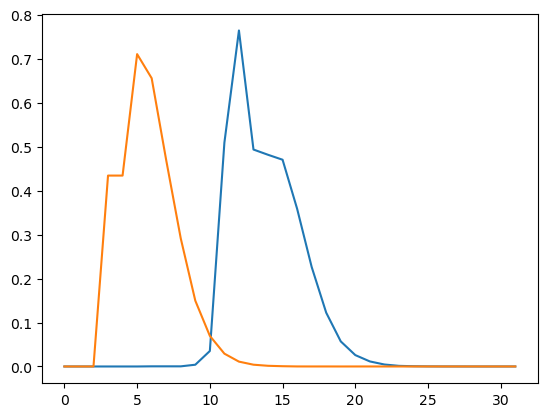

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd426895df0>

In [6]:
bi_ch4 = bitinformation(ch4)
bi_no2 = bitinformation(no2)
plot(bi_ch4)
plot(bi_no2)

In [7]:
kb_ch4 = keepbits(bi_ch4)
kb_no2 = keepbits(bi_no2)

3

In [8]:
no2r = round(no2,kb_no2);
ch4r = round(ch4,kb_ch4);

In [9]:
cf_no2 = round(Int,2*sizeof(no2)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(no2r))))))
cf_ch4 = round(Int,2*sizeof(ch4)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(ch4r))))))

11

In [10]:
function SSIM(  X::AbstractArray{T},
                Y::AbstractArray{T},
                k1::Real=0.01,
                k2::Real=0.03) where T
    
    size(X) == size(Y) || throw(error("Sizes $(size(X)) and $(size(Y)) of inputs don't match."))
    
    μx = mean(X)
    μy = mean(Y)
    
    σx² = var(X,mean=μx)
    σy² = var(Y,mean=μy)
    σxy² = cov(vec(X),vec(Y))
    
    L = max(maximum(X),maximum(Y))-min(minimum(X),minimum(Y))
    c1 = convert(T,(k1*L)^2)
    c2 = convert(T,(k2*L)^2)
    
    numerator = (2μx*μy + c1)*(2σxy² + c2)
    denominator = (μx^2 + μy^2 + c1)*(σx² + σy² + c2)
    return numerator/denominator
end 

SSIM (generic function with 3 methods)

In [12]:
SSIM(Float64.(ch4),Float64.(ch4r))

0.9999997891706635

## Plotting

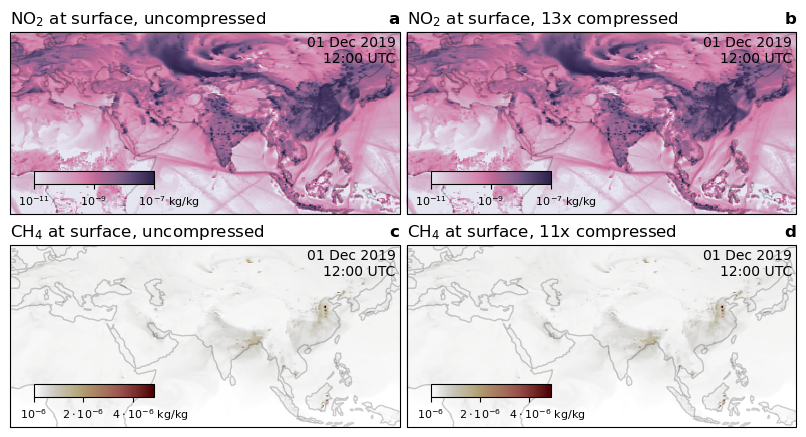

In [222]:
vmin_no2 = -11
vmax_no2 = -7

vmin_ch4 = -6
vmax_ch4 = log10(5.39e-6)

shading = "nearest"
transform = ccrs.PlateCarree()
cmap_no2 = ColorMap(ColorSchemes.acton.colors).reversed()
cmap_ch4 = ColorMap(ColorSchemes.bilbao.colors)

fig,axs = subplots(2,2,sharex=true,sharey=true,figsize=(8,4.5),
                    subplot_kw=Dict("projection"=>ccrs.PlateCarree()))
tight_layout(pad=0.5)

ax1 = axs[1,1]
ax2 = axs[1,2]
ax3 = axs[2,1]
ax4 = axs[2,2]

ax1p = ax1.get_position()
ax2p = ax2.get_position()
ax3p = ax3.get_position()
ax4p = ax4.get_position()

cax1 = fig.add_axes([ax1p.x0+0.03,ax1p.y0+0.08,0.15,0.03])
cax2 = fig.add_axes([ax2p.x0+0.03,ax2p.y0+0.08,0.15,0.03])
cax3 = fig.add_axes([ax3p.x0+0.03,ax3p.y0+0.08,0.15,0.03])
cax4 = fig.add_axes([ax4p.x0+0.03,ax4p.y0+0.08,0.15,0.03])

ax1.set_extent([-5, 145, -10, 60], crs=ccrs.PlateCarree())

q_no2 = ax1.pcolormesh(lon,lat,log10.(no2'),vmin=vmin_no2,vmax=vmax_no2,cmap=cmap_no2;transform,shading)
ax1.coastlines(resolution="110m",alpha=.2)

q_ch4 = ax3.pcolormesh(lon,lat,log10.(ch4'),vmin=vmin_ch4,vmax=vmax_ch4,cmap=cmap_ch4;transform,shading)
ax3.coastlines(resolution="110m",alpha=.2)

tiks_no2 = [1e-11,1e-9,1e-7]
tiklabls_no2 = [L"10^{-11}",L"10^{-9}","         "*L"10^{-7}"*" kg/kg"]

tiks_ch4 = [1e-6,2e-6,4e-6]
tiklabls_ch4 = [L"10^{-6}",L"2\cdot10^{-6}","          "*L"4\cdot10^{-6}"*" kg/kg"]

for cax in [cax1,cax2]
    cb = colorbar(q_no2,cax=cax,orientation="horizontal")
    cb.set_ticks(log10.(tiks_no2))
    cb.set_ticklabels(tiklabls_no2)
    cb.ax.tick_params(labelsize=8)
#     cb.set_label("[kg/kg]",size=8)
end

for cax in [cax3,cax4]
    cb = colorbar(q_ch4,cax=cax,orientation="horizontal")
    cb.set_ticks(log10.(tiks_ch4))
    cb.set_ticklabels(tiklabls_ch4)
    cb.ax.tick_params(labelsize=8)
#     cb.set_label("[kg/kg]",size=8)
end

ax2.pcolormesh(lon,lat,log10.(no2r'),vmin=vmin_no2,vmax=vmax_no2,cmap=cmap_no2;transform,shading)
ax2.coastlines(resolution="110m",alpha=.2)

ax4.pcolormesh(lon,lat,log10.(ch4r'),vmin=vmin_ch4,vmax=vmax_ch4,cmap=cmap_ch4;transform,shading)
ax4.coastlines(resolution="110m",alpha=.2)

ax1.set_title(L"NO$_2$ at surface, uncompressed",loc="left")
ax2.set_title(L"NO$_2$ at surface, "*"$(cf_no2)x compressed",loc="left")

ax3.set_title(L"CH$_4$ at surface, uncompressed",loc="left")
ax4.set_title(L"CH$_4$ at surface, "*"$(cf_ch4)x compressed",loc="left")

for (iax,ax) in enumerate([ax1,ax2,ax3,ax4])
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
end

ax1.text(0.99,0.98,date*" UTC",transform=ax1.transAxes,ha="right",va="top")
ax2.text(0.99,0.98,date*" UTC",transform=ax2.transAxes,ha="right",va="top")
ax3.text(0.99,0.98,date*" UTC",transform=ax3.transAxes,ha="right",va="top")
ax4.text(0.99,0.98,date*" UTC",transform=ax4.transAxes,ha="right",va="top")

savefig("methane_no2_surface.png",dpi=200)

In [223]:
cor(ch4[1:end-1],ch4[2:end])

0.9417187f0

In [224]:
cor(no2[1:end-1],no2[2:end])

0.92240053f0